In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import datasets
import seaborn as sns
from scipy import stats

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
#Read file into dataframe
mta_df = pd.read_csv('mta_data.csv')
mta_df.shape

(204595, 11)

In [3]:
#Clean up weird labeling of "EXITS" column
mta_df = mta_df.rename(columns= {
    'EXITS                                                               ': 'EXITS',
    'C/A': 'CA'})

In [4]:
#Add column for sum total population of people at station ('TOTAL_POP') 
mta_df['TOTAL_POP'] = mta_df['ENTRIES'] + mta_df['EXITS']

In [5]:
#Remove all rows where Datetime isn't on the standard 4-hour collection interval
#Since 'TIME' is a string, can remove rows where last characters aren't '00:00'

mta_df = mta_df.loc[mta_df.TIME.str.contains('00:00') == True]

In [6]:
mta_df.shape

(185836, 12)

In [7]:
#Convert date & time columns to single datetime in new column
mta_df['Datetime'] = mta_df['DATE'] + mta_df['TIME']
mta_df['Datetime'] = mta_df.Datetime.apply(
    lambda x : dt.datetime.strptime(x, "%m/%d/%Y%H:%M:%S"))


#Add column for day of week: 0 = Monday, 6 = Sunday
mta_df['Weekday'] = mta_df.Datetime.apply(
    lambda x: dt.datetime.weekday(x))

In [8]:
#Drop unnecessary columns from dataframe
mta_df_clean = mta_df.drop(columns = ['DATE','TIME','ENTRIES','EXITS'])

In [9]:
#Remove rows that have the "recovered audio" data for the "DESC" column
#--> 'RECOVR AUD' makes up < 1000 rows
#Can drop 'DESC' column after removing those rows
mta_df_clean = mta_df_clean.loc[mta_df_clean['DESC'] != 'RECOVR AUD']
mta_df_clean = mta_df_clean.drop(columns = ['DESC'])

In [10]:
#Group tidy data by Unit, SCP, Station, and Linename to divide each set of 
#population data.

#Entrance/exit counts (now included as total_pop count) change/need to be reset 
#to account for a different starting value at each interval). Assign ID number 
#to each group so we can merge this table with master table.

mta_df_clean_datagroups = mta_df_clean.groupby(
    ['UNIT', 'SCP', 'STATION', 'LINENAME']).size().reset_index(name='Datapoints')

mta_df_clean_datagroups['ID'] = range(len(mta_df_clean_datagroups))

mta_df_clean_datagroups.shape
#Note: each set of population data has approx 42 datapoints

(4460, 6)

In [11]:
#When playing with data in mta_df_clean_datagroups, noticed that columns for 
#CA and DIVISION don't impact the number of data groups, therefore they have 
#no effect on the total_pop count and can be deleted from master table.
#Will delete columns before merging datagroups table with master.

mta_df_clean = mta_df_clean.drop(columns = ['CA','DIVISION'])


In [12]:
#Merge datagroups table with master
mta_df_clean = mta_df_clean.merge(
    mta_df_clean_datagroups,
    on = ['UNIT', 'SCP', 'STATION', 'LINENAME']
)
mta_df_clean

,UNIT,SCP,STATION,LINENAME,TOTAL_POP,Datetime,Weekday,Datapoints,ID
0,R051,02-00-00,59 ST,NQR456W,9360185,2019-03-23 00:00:00,5,42,928
1,R051,02-00-00,59 ST,NQR456W,9360208,2019-03-23 04:00:00,5,42,928
2,R051,02-00-00,59 ST,NQR456W,9360249,2019-03-23 08:00:00,5,42,928
3,R051,02-00-00,59 ST,NQR456W,9360436,2019-03-23 12:00:00,5,42,928
4,R051,02-00-00,59 ST,NQR456W,9360773,2019-03-23 16:00:00,5,42,928
5,R051,02-00-00,59 ST,NQR456W,9361185,2019-03-23 20:00:00,5,42,928
6,R051,02-00-00,59 ST,NQR456W,9361382,2019-03-24 00:00:00,6,42,928
7,R051,02-00-00,59 ST,NQR456W,9361411,2019-03-24 04:00:00,6,42,928
8,R051,02-00-00,59 ST,NQR456W,9361448,2019-03-24 08:00:00,6,42,928
9,R051,02-00-00,59 ST,NQR456W,9361591,2019-03-24 12:00:00,6,42,928


In [13]:
#Create a df of first population readings for each ID (columns: ID, TOTAL_POP)

firsts = pd.concat([pd.DataFrame([mta_df_clean.loc[(mta_df_clean['ID'] == i), ['ID', 'TOTAL_POP']].iloc[0]], 
                                columns=['ID', 'TOTAL_POP']) for i in range(len(mta_df_clean_datagroups))], 
                                ignore_index=True)
firsts = firsts.rename(columns = {'TOTAL_POP': 'first_pop_reading'})
firsts.shape

(4460, 2)

In [14]:
#Merge firsts table with data_clean table, so we can then subtract first pop
#value from successive values for each datagroup

mta_df_clean = mta_df_clean.merge(
    firsts,
    on = ['ID']
)

In [15]:
mta_df_clean['adj_pop'] = mta_df_clean['TOTAL_POP'] - mta_df_clean['first_pop_reading']

mta_df_clean.shape

(185147, 11)

In [16]:
#Now can group adjusted pop data for each station together, to get total 
#pop counts for each station

#Group by datetime, station name, sum adjusted pop counts

pop_timeseries_by_station = mta_df_clean.groupby(['STATION','Datetime','Weekday'])['adj_pop'].sum().reset_index()
pop_timeseries_by_station

,STATION,Datetime,Weekday,adj_pop
0,1 AV,2019-03-23 00:00:00,5,0
1,1 AV,2019-03-23 04:00:00,5,1317
2,1 AV,2019-03-23 08:00:00,5,2170
3,1 AV,2019-03-23 12:00:00,5,5829
4,1 AV,2019-03-23 16:00:00,5,12698
5,1 AV,2019-03-23 20:00:00,5,21253
6,1 AV,2019-03-24 00:00:00,6,27357
7,1 AV,2019-03-24 04:00:00,6,28955
8,1 AV,2019-03-24 08:00:00,6,29320
9,1 AV,2019-03-24 12:00:00,6,32272


In [29]:
#Want to get stations with highest average daily population
#Need to get diffs for each day's pop data

pop_timeseries_by_station['pop_over_time_diffs'] = pop_timeseries_by_station.adj_pop.diff()

#Remove rows with values less than zero
pop_timeseries_by_station = pop_timeseries_by_station.loc[
    pop_timeseries_by_station['pop_over_time_diffs'] >= 0]

#remove outliers
pop_timeseries_by_station = pop_timeseries_by_station[
    (np.abs(stats.zscore(pop_timeseries_by_station['pop_over_time_diffs'])) < 3).all(axis=1)]

#avg_daily_pop_by_station


#pop_timeseries_by_station

KeyError: False

In [18]:
total_pop_by_station = pop_timeseries_by_station.groupby(['STATION']
                                                        ).agg({'adj_pop':'max'}
                                                        ).sort_values('adj_pop', ascending=False)
total_pop_by_station.shape

(360, 1)

In [19]:
#remove rows with adj_pop = 0

total_pop_by_station = total_pop_by_station.loc[total_pop_by_station['adj_pop'] > 0]

total_pop_by_station.shape

(356, 1)

In [20]:
#remove outliers
from scipy import stats
total_pop_stations_outliers_removed = total_pop_by_station[
    (np.abs(stats.zscore(total_pop_by_station)) < 3).all(axis=1)]

#top 20 stations based on total population for the week
top_20_stations_pop_week = total_pop_stations_outliers_removed[0:20]
top_20_stations_pop_week

,adj_pop
STATION,
34 ST-HERALD SQ,1396296
34 ST-PENN STA,1341410
TIMES SQ-42 ST,1173672
GRD CNTRL-42 ST,854811
59 ST COLUMBUS,820974
47-50 STS ROCK,719222
23 ST,691793
59 ST,672529
FLUSHING-MAIN,661356


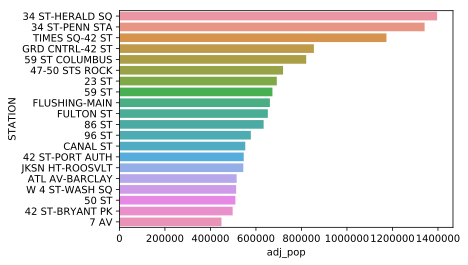

In [21]:
#Plot total adj pop data using seaborn
top_20_stations_pop_week_plt = top_20_stations_pop_week.reset_index(level=0)
sns.barplot(y = 'STATION', x = 'adj_pop',data=top_20_stations_pop_week_plt);

In [22]:
#Plot how data changes throughout the day at 20 stations with highest daily average
#Make recommendations for best times of day to position street teams at which stations

In [23]:
#Need to use .diff() to come up with population change for each subset of data w/in same station
#Could use timestamps to subtract earliest reading for each subset from TOTAL_POP, then use those
#to get a better idea of total amt of people at station at any time

#Assumption: min pop is at earliest time for each unit/special section of each station

#So... need to chunk individual sets (not uniform number for each unit)
#Write loop that compares values of certain columns to row above it, if there's a change, reset pop counter

#If there's a change in rows 0:5, that means switch to different input data. 

#def NormalizeTotalPop(total_pop):
#    for total_pop


In [24]:
#Notes from Aaron for cutting out outliers 
# df[df.Ent < 1e9]

In [25]:
#Google API to find locations of stations

In [26]:
#proximity to universities (nyu , columbia/Barnard, fordham, city university?), google (14th st (x2), 8th ave, 18th st)
#peloton, map wework??, squarespace, vimeo, etsy (brooklyn), bloomberg, rent the runway

# Notes
#map change in total population from start of the week? 
#Can't do it based on decrease in weekday, since not all data points have all days
#Can do it based on when total_pop decreases? No, won't work for all transitions


#WHEN SCP CHANGES, that's when pop count changes
#write a function that will subtract first value in SCP interval from all pop counts
#in that interval, then end interval when SCP changes

#maybe this is 2 functions? one to chunk the data (perhaps create a new temporary column
#to enumerate chunks of data --> That way there's no overlap in SCP numbers)
